In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import os
from collections import defaultdict
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import Counter
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))|set(stopwords.words('russian'))

import warnings 
warnings.filterwarnings(action = 'ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikhailzaytsev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mikhailzaytsev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('content/')

In [ ]:
os.listdir('content/My Drive/')

In [ ]:
positive = pd.read_csv('positive_twits.csv', sep=';', header=None) # load data
negative = pd.read_csv('negative_twits.csv', sep=';', header=None)

In [ ]:
positive.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [ ]:
negative.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [ ]:
len(positive), len(negative)

(114911, 111923)

In [ ]:
positive['target'] = 1 # добавим лейблы
negative['target'] = 0

In [ ]:
data = pd.concat([positive, negative], ignore_index=True)
data.drop([0,1,2,4,5,6,7,8,9,10,11], axis=1, inplace=True) # drop everything, except tweet text
data.rename(columns={3:'tweet'}, inplace=True)

print(data.shape)
data.head()

(226834, 2)


,tweet,target
0,"@first_timee хоть я и школота, но поверь, у на...",1
1,"Да, все-таки он немного похож на него. Но мой ...",1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [ ]:
data['tweet'].iloc[4]

'@irina_dyshkant Вот что значит страшилка :D\nНо блин,посмотрев все части,у тебя создастся ощущение,что авторы курили что-то :D'

In [ ]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=17)
print(len(train), len(test))

181467 45367


In [ ]:
print('Train_dataset: \n {}'. format(train['target'].value_counts()))
print('Test_dataset: \n {}'. format(test['target'].value_counts()))

Train_dataset: 
 1    91877
0    89590
Name: target, dtype: int64
Test_dataset: 
 1    23034
0    22333
Name: target, dtype: int64


In [ ]:
print('Positive: {}'.format(train.loc[train['target']==1, 'tweet'].iloc[0]))
print('Negative: {}'.format(train.loc[train['target']==0, 'tweet'].iloc[0]))

Positive: @palmen27121 представляю :р
первые твиты обо мне? лестно)
Negative: RT @10nyk: Не пускають до Баті :( http://t.co/HnB6H2na4L


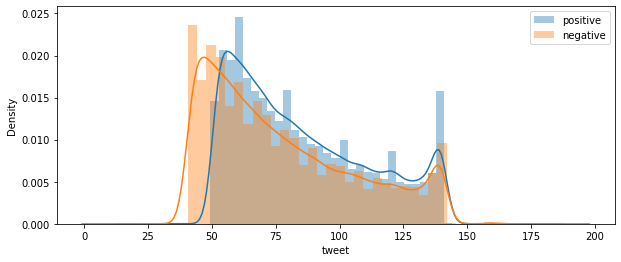

In [ ]:
# Number of symbols in a tweet
plt.figure(figsize=(10,4))
sns.distplot(train.loc[train['target']==1, 'tweet'].apply(lambda x: len(x)), label='positive')
sns.distplot(train.loc[train['target']==0, 'tweet'].apply(lambda x: len(x)), label='negative')
plt.legend(loc=0);

## Делаем препроцессинг текста, удаляем ссылки, тэги, знаки препинания и тд.

In [ ]:
emotions = [] # популярные смайлики
for i in train['tweet'].apply(lambda x: re.findall(r':\S\S?', x)):
  if len(i)>0:
    emotions.append(i[0])

In [ ]:
pd.Series((emotions)).value_counts().head(20)

:(     23863
://    16706
:)     13231
:D     11212
:((     3872
:-)     2390
:))     2256
:*      1939
:-(     1822
:DD     1599
:3      1202
:|       735
:-D      481
:**      433
:с       414
:-/      363
:з       206
:00      182
:15      146
:33      139
dtype: int64

In [ ]:
train['tweet'][:2]

17538    @palmen27121 представляю :р\nпервые твиты обо ...
29230    Так круто в трусах и майке по морозу^^ сразу п...
Name: tweet, dtype: object

In [ ]:
example= '@palmen27121 представляю :3 :р \
первые твиты обо мне? лестно) \
RT @10nyk: Не пускають до Баті :( http://t.co/HnB6H2na4L'

smiles = {
    ":(":"грусть",
    "3(":"грусть",
    ":-(":"грусть",
    ":((":"грусть",
    "((":"грусть",
    "(((":"грусть",
    ":)":"радость",
    ":-)":"радость",
    ":))":"радость",
    "))":"радость",
    ")))":"радость",
    ":3":"радость",
    ":з":"радость",
    ":*":"поцелуй",
    ":**":"поцелуй",
    ":d":"смех",
    ":dd":"смех",
    ":-d":"смех",
    ':-/':'недовольство',
    ':/':'недовольство',
    ':|':'нейтрально',
    ':-|':'нейтрально',
    ':0': 'удивление',
    ':00': 'удивление',
    ':-0': 'удивление',
    ':o': 'удивление',
    ':-o': 'удивление',
    ':о': 'удивление',
    ':-о': 'удивление',
    'o_o': 'удивление',
    '0_0': 'удивление',
    'о_о': 'удивление',
    ':р': 'усмешка',
    ':p': 'усмешка',
    ':-p': 'усмешка',
    ':-р': 'усмешка',
}

train['tweet'] = train['tweet'].apply(lambda x: [smiles[i] if i in smiles.keys() else i for i in x.split()])
train['tweet'] = train['tweet'].apply(lambda x: ' '.join(x))
test['tweet'] = test['tweet'].apply(lambda x: [smiles[i] if i in smiles.keys() else i for i in x.split()])
test['tweet'] = test['tweet'].apply(lambda x: ' '.join(x))

# Functions to clean tweets

def lowering(text):
    return text.lower()

def remove_tags(text):
    """Remove tags (@)"""
    return re.sub(r'@[\w\d]*\b', '', text) 

def remove_abbrev(text):
    """Remove 'rt', ... """
    return re.sub(r'rt\b', '', text) 

def remove_URL(text):
    """Remove links"""
    url = re.compile(r'http\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    """Remove punctuation"""
    return re.sub(r'[^\w\s]','', text) 

def remove_individ_letters(text):
    """Удаляем одиночные английские и русские буквы"""
    return re.sub(r'\b\w\b','', text) 

def clean_text(text):
    x = lowering(text)
    x = remove_abbrev(x)
    x = remove_URL(x)
    x = remove_tags(x)
    x = remove_punct(x)
    return remove_individ_letters(x)

print('Without abbrev: {}\n'.format(remove_abbrev(example)))
print('Without tags: {}\n'.format(remove_tags(example)))
print('Without URLs: {}\n '.format(remove_URL(example)))
print('Without puncts: {}\n'.format(remove_punct(example)))
print('Cleaned text: {}'.format(clean_text(example)))


Without abbrev: @palmen27121 представляю :3 :р первые твиты обо мне? лестно) RT @10nyk: Не пускають до Баті :( http://t.co/HnB6H2na4L

Without tags:  представляю :3 :р первые твиты обо мне? лестно) RT : Не пускають до Баті :( http://t.co/HnB6H2na4L

Without URLs: @palmen27121 представляю :3 :р первые твиты обо мне? лестно) RT @10nyk: Не пускають до Баті :( 
 
Without puncts: palmen27121 представляю 3 р первые твиты обо мне лестно RT 10nyk Не пускають до Баті  httptcoHnB6H2na4L

Cleaned text:  представляю   первые твиты обо мне лестно   не пускають до баті  


In [ ]:
train['tweet'] = train['tweet'].apply(lambda x: clean_text(x))
test['tweet'] = test['tweet'].apply(lambda x: clean_text(x))

In [ ]:
train.head()

,tweet,target
17538,представляю усмешка первые твиты обо мне лестно,1
29230,так круто трусах майке по морозу сразу просн...,1
181833,не пускають до баті грусть,0
162693,как то не то без экзаменов нет чувства накала ...,0
209207,вечно всё порчу грусть довёл любимую грусть ...,0


In [ ]:
# make coprus of words 
def create_corpus_train(target):
    corpus = []
    for i in train.loc[train['target']==target, 'tweet'].str.split():
        for x in i:
            corpus.append(x.lower())
    return corpus

corpus_0 = create_corpus_train(0)
corpus_1 = create_corpus_train(1) # посмотрим на распределения слов в двух сетах (+ и -)

In [ ]:
print(corpus_0[:20])
print(corpus_1[:20])

['не', 'пускають', 'до', 'баті', 'грусть', 'как', 'то', 'не', 'то', 'без', 'экзаменов', 'нет', 'чувства', 'накала', 'грусть', 'вечно', 'всё', 'порчу', 'грусть', 'довёл']
['представляю', 'усмешка', 'первые', 'твиты', 'обо', 'мне', 'лестно', 'так', 'круто', 'трусах', 'майке', 'по', 'морозу', 'сразу', 'проснулась', 'было', 'же', 'время', 'парк', 'возле']


In [ ]:
# Популярные стоп-слова в твитах
def popular_stop_words(corpus):
    stop_words_dict = defaultdict(int)
    for word in corpus:
        if word in STOP_WORDS:
            stop_words_dict[word]+=1
    return stop_words_dict

stop_words_dict_0 = popular_stop_words(corpus_0)
stop_words_dict_1 = popular_stop_words(corpus_1)

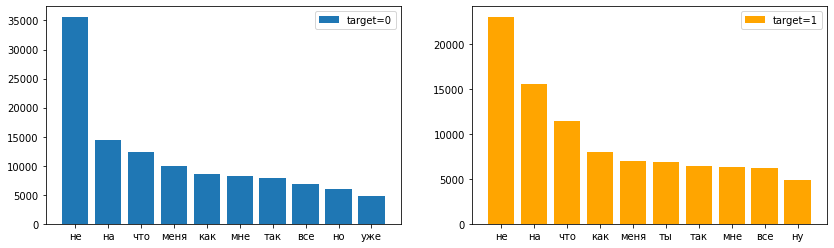

In [ ]:
# Visualize top-10 popular stopwords in tweets with target = 0/1
top_stop_0 = sorted(stop_words_dict_0.items(), key=lambda x: x[1], reverse=True)[:10]
top_stop_1 = sorted(stop_words_dict_1.items(), key=lambda x: x[1], reverse=True)[:10]

plt.figure(figsize=(14,4))
plt.subplot(121)
x,y = zip(*top_stop_0)
plt.bar(x, y, label='target=0')
plt.legend(loc=0);
plt.subplot(122)
x,y = zip(*top_stop_1)
plt.bar(x,y, label='target=1', color='orange')
plt.legend(loc=0);

# особо нет различий

In [ ]:
# Посмотрим на популярные слова в твитах

def popular_words(corpus):
    counter = Counter(corpus)
    x, y = [], []
    for word, n in counter.most_common():
        if len(x)<10 and word not in STOP_WORDS:
            x.append(word)
            y.append(n)
    return x,y

In [ ]:
popular_words(corpus_0)

(['грусть',
  'это',
  'хочу',
  'сегодня',
  'очень',
  'день',
  'завтра',
  'могу',
  'просто',
  'блин'],
 [21142, 6564, 4343, 3347, 3008, 2597, 2429, 2323, 2250, 2163])

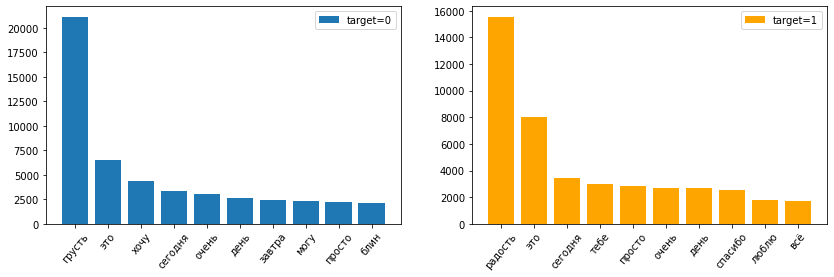

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(121)
x,y = popular_words(corpus_0)
plt.bar(x,y, label='target=0')
plt.xticks(rotation=50)
plt.legend(loc=0)

plt.subplot(122)   
x,y = popular_words(corpus_1)
plt.bar(x,y, color='orange', label='target=1') 
plt.xticks(rotation=50)
plt.legend(loc=0)


## Тренируем word2vec для RNN

In [ ]:
# Попробуем натренировать собственные вектора
from nltk.tokenize import word_tokenize 

import gensim 
from gensim.models import Word2Vec

In [ ]:
df = pd.concat([train, test])

In [ ]:
data = [] 

# iterate through each tweet in the file 
for i in train['tweet']: 
    temp = [] 
    
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        temp.append(j) 
  
    data.append(temp)

In [ ]:
data[:4]

[['представляю', 'усмешка', 'первые', 'твиты', 'обо', 'мне', 'лестно'],
 ['так', 'круто', 'трусах', 'майке', 'по', 'морозу', 'сразу', 'проснулась'],
 ['не', 'пускають', 'до', 'баті', 'грусть'],
 ['как',
  'то',
  'не',
  'то',
  'без',
  'экзаменов',
  'нет',
  'чувства',
  'накала',
  'грусть']]

In [ ]:
model1 = gensim.models.Word2Vec(data, min_count = 2, vector_size = 100, window = 5) # CBOW

model2 = gensim.models.Word2Vec(data, min_count = 2, vector_size = 100, window = 5, sg = 1) # SkipGram

In [ ]:
model1.wv.most_similar('супер')

[('замечательно', 0.9020270705223083),
 ('шикарно', 0.8885408043861389),
 ('гавно', 0.8855655193328857),
 ('пиздато', 0.885222852230072),
 ('солнце', 0.883987545967102),
 ('неплохо', 0.8810324668884277),
 ('миленько', 0.8805614113807678),
 ('семейный', 0.8805434703826904),
 ('спасибки', 0.8710744976997375),
 ('общемто', 0.8703016638755798)]

## Собираем модель

In [ ]:
data[:3]

[['представляю', 'усмешка', 'первые', 'твиты', 'обо', 'мне', 'лестно'],
 ['так', 'круто', 'трусах', 'майке', 'по', 'морозу', 'сразу', 'проснулась'],
 ['не', 'пускають', 'до', 'баті', 'грусть']]

In [ ]:
MAX_LENGTH = 25

tokenizer = Tokenizer() # для представления слов числами
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])
sequences_pad = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_LENGTH, 
                                                           padding='post', truncating='post')

In [ ]:
sequences_pad[:3]

array([[ 1198,  6048,  1164,   894,  1097,     9, 32533,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [   10,   189,  7540, 11355,    14,  4297,   193,   513,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [    1, 23820,    45, 27463,     4,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]], dtype=int32)

In [ ]:
word_index = tokenizer.word_index
num_words = len(word_index)+1

print('N unique words: {}'.format(num_words))
print('Individual words: {}'.format(list(word_index.items())[:5]))

N unique words: 245300
Individual words: [('не', 1), ('на', 2), ('что', 3), ('грусть', 4), ('меня', 5)]


In [ ]:
embedding_matrix = np.zeros((num_words, 100)) # матрица представления всех слов векторами

for word,i in word_index.items():
    try:
        embedding_vect = model1.wv.get_vector(word)
    except: 
        embedding_vect = None
    if embedding_vect is not None:
        embedding_matrix[i] = embedding_vect
        
embedding_matrix.shape

(245300, 100)

In [ ]:
train_seq = sequences_pad[:train.shape[0]] # разделяем на train/test
test_seq = sequences_pad[train.shape[0]:]

print(train_seq.shape, test_seq.shape)

(181467, 25) (45367, 25)


In [ ]:
# попробуем LSTM
model_input = keras.Input(shape=(None,))
x = keras.layers.Embedding(num_words, 100, 
                           embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                           input_length=MAX_LENGTH, trainable=False)(model_input)
x = keras.layers.Bidirectional(keras.layers.LSTM(300, dropout=0.3, return_sequences=False))(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
model_output = keras.layers.Dense(1)(x)

model = keras.Model(model_input, model_output, name='LSTM')

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         24530000  
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               962400    
_________________________________________________________________
dense (Dense)                (None, 128)               76928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 25,569,457
Trainable params: 1,039,457
Non-trainable params: 24,530,000
__________________________________________

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=2, verbose=1)

callbacks = [early_stop, reduce_lr,]

history = model.fit(train_seq, train['target'], batch_size=256, epochs=50, validation_split=0.2, callbacks=callbacks)

Epoch 1/5
568/568 [==============================] - 156s 275ms/step - loss: 0.5178 - accuracy: 0.6903 - val_loss: 0.4952 - val_accuracy: 0.7173
Epoch 2/5
568/568 [==============================] - 173s 304ms/step - loss: 0.5082 - accuracy: 0.6967 - val_loss: 0.4966 - val_accuracy: 0.7325
Epoch 3/5
568/568 [==============================] - 184s 324ms/step - loss: 0.5014 - accuracy: 0.7036 - val_loss: 0.4908 - val_accuracy: 0.7374
Epoch 4/5
414/568 [====================>.........] - ETA: 1:04 - loss: 0.4970 - accuracy: 0.7060

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend(loc=0)